In [1]:
import numpy as np 
import pandas as pd 

import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential,Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization,Input,UpSampling2D
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import regularizers
import cv2
from tqdm import tqdm
import random
from skimage.io import imread
from skimage.transform import resize
import numpy as np
from tensorflow.keras.utils import Sequence
import random
from keras import backend as K
import sys

In [2]:
def preprocess_img(img_path):
    dsize = (224,224)
    new_image=cv2.imread(img_path)
    new_image=cv2.resize(new_image,dsize)  
    new_image=np.expand_dims(new_image,axis=0)
    new_image=np.flip(new_image,axis=-1)
    return new_image

In [3]:
img_width, img_height = (256, 256)
BATCH_SIZE = 32

In [4]:
example = pd.read_csv('examples_of_retrieval.csv', sep="\t")
retrievals=[]
retrievals.append([x.replace(" ", "") for x in example.columns[0].split(",")])
for i in example.index:
    retrievals.append([x.replace(" ", "") for x in example.iloc[i].values[0].split(",")])

In [5]:
paths = os.listdir('./dataset/database-full/')

In [6]:
len(paths)

31783

In [ ]:
# similar_pairs   = []
# unsimilar_pairs = []

# for group in retrievals:
#     for i in range(len(group)):
#         for item in group[i+1:]:
#             similar_pairs.append([group[i], item, 1])
            
#             nums_in_group = [x[5:-4] for x in group]    
#             nums_in_group.append('11396')
            
#             different = random.randint(0, len(paths))
#             while str(different) in nums_in_group:
#                 different = random.randint(0, len(paths))

#             unsimilar_pairs.append([group[i], 'image'+str(different)+'.jpg', 0])
            
            
similar_pairs   = []
unsimilar_pairs = []


similar_pairs_val   = []
unsimilar_pairs_val = []

for group in retrievals:
    nums_in_group = [x[5:-4] for x in group]    
    nums_in_group.append('11396')
    
    similar_pairs_val.append([group[0], group[-1], 1])
    
    different = random.randint(0, len(paths))
    while str(different) in nums_in_group:
        different = random.randint(0, len(paths))
    unsimilar_pairs_val.append([group[random.randint(0, len(group)-1)], 'image'+str(different)+'.jpg', 0])
    
    if len(group)%2!=0:
        group.append(group[0])
    cont=0
    while cont<len(group):
        different = random.randint(0, len(paths))
        while str(different) in nums_in_group:
            different = random.randint(0, len(paths))
        similar_pairs.append(group[cont:cont+2])
        unsimilar_pairs.append([group[cont],'image'+str(different)+'.jpg'])
        
        similar_pairs[-1].append(1)
        unsimilar_pairs[-1].append(0)
        
        cont+=2

In [ ]:
X = similar_pairs + unsimilar_pairs

In [ ]:
X_val = similar_pairs_val + unsimilar_pairs_val

In [ ]:
random.shuffle(X)
X = np.array(X)

In [ ]:
random.shuffle(X_val)
X_val = np.array(X_val)

In [ ]:
prefix = r'C:\Users\Rod\Desktop\Tarea 3\dataset\database-full\ '

class CustomDataGenerator(Sequence):
    def __init__(self, x_set, batch_size, width, height):
        self.x = x_set
        self.batch_size = batch_size
        self.width  = width
        self.height = height

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):

        batch_ = self.x[idx * self.batch_size : (idx + 1) * self.batch_size]
        
        batch_x = batch_[:,0]
        batch_y = batch_[:,1]
        
        labels =  batch_[:,2].astype(int)
        
        batch_x = [resize(imread(prefix +file_name), (self.width, self.height)) for file_name in batch_x]
        batch_y = [resize(imread(prefix +file_name), (self.width, self.height)) for file_name in batch_y]
        
        return [np.array(batch_x), np.array(batch_y)], labels
    
class CustomTestDataGenerator(Sequence):
    def __init__(self, x_set, batch_size, width, height, prefix1, prefix2, imgs_to_pred):
        self.x = x_set
        self.batch_size = batch_size
        self.width  = width
        self.height = height
        self.prefix1 = prefix1
        self.prefix2 = prefix2
        self.imgs_to_pred = imgs_to_pred
        self.cont = 0
        
        self.batch_y = np.array([resize(imread(prefix2 +file_name), (width, height)) for file_name in x_set[0: batch_size][:,1]])
        
        self.cut = len(x_set) / imgs_to_pred
        
    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):

        batch_ = self.x[idx * self.batch_size : (idx + 1) * self.batch_size]
        
        batch_x = batch_[:,0]

        if(self.cont >= self.cut):
            print("entered")
            batch_y = batch_[:,1]
            self.cont = 0
            self.batch_y = np.array([resize(imread(self.prefix2 +file_name), (self.width, self.height)) for file_name in batch_y])
        self.cont += self.batch_size
        
        batch_x = [resize(imread(self.prefix1 +file_name), (self.width, self.height)) for file_name in batch_x]
        #batch_y = [resize(imread(self.prefix2 +file_name), (self.width, self.height)) for file_name in batch_y]
        
        return ({"input_3": np.array(batch_x), "input_4": self.batch_y})
    
    
class CustomTestDataGenerator3(Sequence):
    def __init__(self, x_set, batch_size, width, height, prefix):
        self.x = x_set
        self.batch_size = batch_size
        self.width  = width
        self.height = height
        self.prefix = prefix
        
    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):

        batch_x = self.x[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_x = [resize(imread(self.prefix + file_name), (self.width, self.height)) for file_name in batch_x]
    
        return np.array(batch_x)

In [ ]:
# (a,b),c = [CustomDataGenerator(X, 1, img_width, img_height).__getitem__(56)][0]

In [ ]:
# print(c)
# plt.imshow(a[0])
# plt.show()
# plt.imshow(b[0])
# plt.show()

In [ ]:
# We have 2 inputs, 1 for each picture
left_input = Input((img_width, img_height,3))
right_input = Input((img_width, img_height,3))

# We will use 2 instances of 1 network for this task
convnet = Sequential([
    layers.Conv2D(5,3, input_shape=(img_width, img_height,3)),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(5,3),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(7,2),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(7,2),
    layers.Activation('relu'),
    layers.Flatten(),
    layers.Dense(18),
    layers.Activation('sigmoid')
])
# Connect each 'leg' of the network to each input
# Remember, they have the same weights
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

# Getting the L1 Distance between the 2 encodings
L1_layer = layers.Lambda(lambda tensor:K.abs(tensor[0] - tensor[1]))

# Add the distance function to the network
L1_distance = L1_layer([encoded_l, encoded_r])

prediction = Dense(1,activation='sigmoid')(L1_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

optimizer = tf.keras.optimizers.Adam()#Adam(0.001, decay=2.5e-4)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_net.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])

In [ ]:
siamese_net.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 18)           106704      ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [ ]:
data_train_gen = CustomDataGenerator(X, BATCH_SIZE, img_width, img_height)

In [ ]:
data_val_gen = CustomDataGenerator(X_val, BATCH_SIZE, img_width, img_height)

In [ ]:
history = siamese_net.fit(data_train_gen, validation_data=data_val_gen, epochs=2)

Epoch 1/2
96/96 [==============================] - 190s 2s/step - loss: 0.6876 - accuracy: 0.5454 - val_loss: 0.6875 - val_accuracy: 0.5700
Epoch 2/2
96/96 [==============================] - 186s 2s/step - loss: 0.6693 - accuracy: 0.6036 - val_loss: 0.6803 - val_accuracy: 0.6100


In [ ]:
left_pos_model = Model(left_input, encoded_l)
right_post_model = Model(right_input, encoded_r)

In [ ]:
dataset_gen = CustomTestDataGenerator3(paths, BATCH_SIZE, img_width, img_height, prefix[:-1])

In [ ]:
dataset_pos_preds = right_post_model.predict(dataset_gen, verbose = 1)

994/994 [==============================] - 906s 911ms/step


In [ ]:
queries_imgs = pd.read_csv('names_test_queries.csv', sep="\t", header=None).values.squeeze()
queries_gen = CustomTestDataGenerator3(queries_imgs, BATCH_SIZE, img_width, img_height, prefix[:-1])

In [ ]:
queries_pos_preds = left_pos_model.predict(queries_gen, verbose = 1)

27/27 [==============================] - 25s 923ms/step


In [ ]:
distance_descriminator = Model(L1_distance, prediction)

pred_labels = []
for query_pos_pred in tqdm(queries_pos_preds):
    pred_labels.append( distance_descriminator.predict( np.array([K.abs(query_pos_pred - dataset_pos_pred) for dataset_pos_pred in dataset_pos_preds]), verbose=0) )
    sys.stdout.flush()

100%|███████████████████████████████████████████████████████████████████████████████████| 861/861 [1:51:48<00:00,  7.79s/it]


In [ ]:
np.save('pred_labels.npy', pred_labels)

In [ ]:
pred_labels = np.array(pred_labels)

In [ ]:
pred_labels = pred_labels.squeeze()

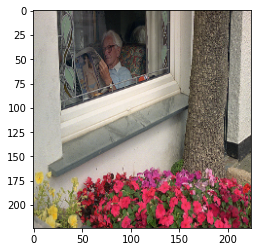

In [ ]:
plt.imshow( preprocess_img(prefix[:-1]+queries_imgs[860])[0] )

In [ ]:
most_sim_0 = np.array(paths)[pred_labels[860] > .55]

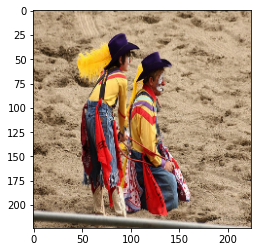

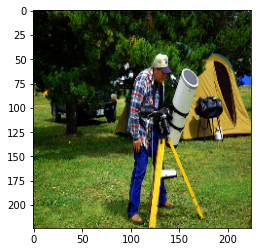

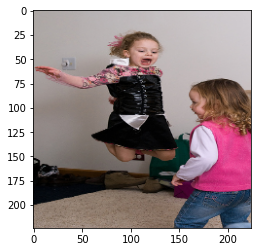

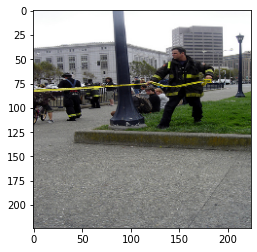

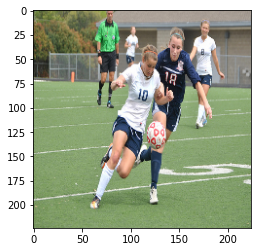

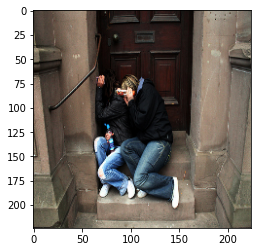

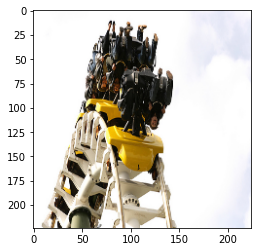

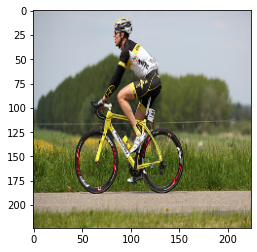

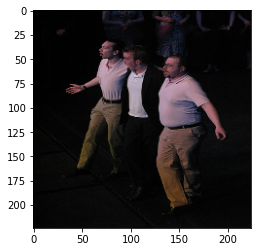

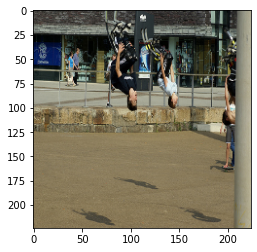

In [ ]:
for im in most_sim_0[:10]:
    plt.imshow( preprocess_img(prefix[:-1]+im)[0] )
    plt.show()

In [ ]:
indices = np.array([x[6:-4] for x in paths])

In [ ]:
data = []

for row in pred_labels:
    most_sim_scores = row[row > .55]
    most_sim_names  = indices[row > .55]
    
    tup = [(x,y) for x,y in zip(most_sim_names, most_sim_scores)]
    
    data.append(np.array(sorted(tup, key = lambda x: x[1], reverse=True))[:,0])

In [ ]:
nums = [x[6:-4] for x in queries_imgs]

In [ ]:
df = pd.DataFrame({'Id':nums, 'Expected': [" ".join(x) for x in data]})

In [ ]:
df = df.set_index('Id')

In [ ]:
df.to_csv('maoma_malo.csv')

In [ ]:
# bound = len(X)//BATCH_SIZE - 2
# for i in tqdm(range(len(X)//BATCH_SIZE)):
    
#     random_index = random.randint(0, bound)
#     (left, right), labels = data_gen.__getitem__(random_index)        
#     siamese_net.train_on_batch([left, right], labels)

In [ ]:
siamese_net.save('nico_siamese.h5')

In [ ]:
X_test = []
for p in paths:
    X_test.append([p.replace(" ", ""), 'flauta.jpg'])
    
#y_pred2 = [siamese_net.predict([test_gen.__getitem__(i)]) for i in tqdm(range(len(X_test)//BATCH_SIZE))]

In [ ]:
test_gen = CustomTestDataGenerator(np.array(X_test), BATCH_SIZE, img_width, img_height, prefix, r'C:\Users\Rod\Desktop\Tarea 3\test\test\ '[:-1], 1)

In [ ]:
y_pred = siamese_net.predict(test_gen, verbose=1)

c:\users\rod\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


KeyboardInterrupt: 

In [ ]:
mask = np.array(y_pred).squeeze()
similars = np.array(X_test)[mask > .95][:,0]

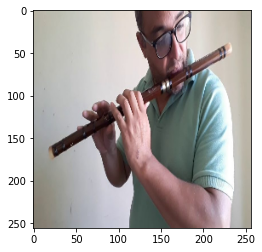

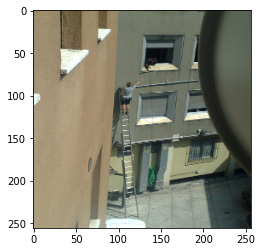

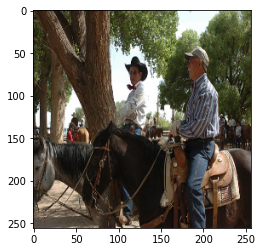

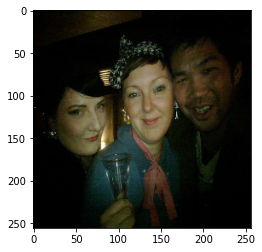

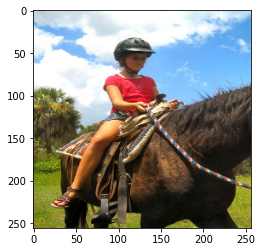

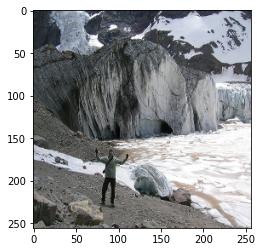

In [ ]:
plt.imshow(preprocess_img(r'C:\Users\Rod\Desktop\Tarea 3\test\test\flauta.jpg')[0])
plt.show()

for simi in similars[:10]:
    plt.imshow(preprocess_img(prefix + simi)[0])
    plt.show()